# Final Version 3

<b><i> Identified [Aim](#aim) of the project as, see link to later in document

### External Modules

In [1]:
import numpy as np
import pandas as pd
import ADRpy as ADR
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
plt.rcParams["figure.figsize"]=15,10 #Set plot size
plt.rcParams.update({'font.size': 16}) #set plot size font
plt.rcParams.update({"axes.grid" : True, "grid.color": "lightgrey"}) #Add grid lines to plot

### Conversions

In [3]:
def Knots(MS):
    return MS / 0.5144

def MS(Knots):
    return Knots * 0.5144

def radian(degree):
    return degree * np.pi/180

### Environment Parameters

In [4]:
g = 9.81        #Gravitational Constant
rho = 1.225

# Wind Speed / Direcion
#     Headwind +ve
#     Cross wind +ve from right
w_vel = 0
w_deg = 0

mu = 0.05    #Driction Coefficient to Runway Surface

#Possibly ovveride given rho (using ISA altitudes)
temp_c = 15     #Airfield OAT temperacture in celcius
alt_ft = 83     #Airfield (runway) altitude in feet
RunwayLength = 1650

In [5]:
# Vw = MS(5) #5 kt headwind
Vw = 0

<div class="alert alert-block alert-info">
Reasonable approximation of g to 9.81 as still very close to this. Density can be resonably approximated to 1.225 as very close to sea level given in relation. only change to the density will come from the temperature change, so use of ADRpy to calculate is ideal, on standard ISA non-offset (research into the offset and why used should be looked at)
</div>

### Aircraft Parameters

#### Airframe

In [6]:
m = 54000        #Mass

S = 122.6        #Wing Area
h_W = 3.38      #Height of wing above the ground

b = 34.1       #Wingspan

c = S/b       #Chord length

In [7]:
A = (b**2)/S
e = 0.85
a0 = 2*np.pi
alpha_0L = - radian(2)

def CL(alpha):
    alpha1 = radian(alpha)
    return a0 * ((np.pi*A*e)/(np.pi*A*e + a0)) * (alpha1 - alpha_0L)

#def Cl(alpha):
#    a0 = 2*np.pi
#    alpha0 = radian(2)
#    
#    return a0*(alpha + alpha0/57.3)

In [8]:
CD0 = 0.02

#### Engine

In [9]:
T = 120.6 * 1e3     #Thrust per engine
n_e = 2   #Number of engines (evenly distributed per wing (i.e. 2 engines = 1 per wing))

### Engine Failure Parameters  (likely not be necessary*)
<i>* Due to running a balanced field model, engine failure is automatically used in calculating this, as such the needed for a failure speed isn't required (this will be covered by the calculated V1 speed). `However, the engine that fails is a parameter that will likely be used and will be an input controlled by the overall Monte Carlo analysis`

In [10]:
V_fail = 0    #Speed at which failure occurs
E_Ident = 0   #Engine Number to fail

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Key Functions

- Lift
- Drag
- Ground Effect
- Friction
- Induced Drag
- phi
<br>

* ODEs for:
    * Velocity
    * Distance travelled

<div class="alert alert-block alert-warning">
Check definition of lift when using total Cl (i.e. when tail is included as well, which S is needed)
</div>
<div class="alert alert-block alert-warning">
Define Drag components seperately (Profile, Induced, Friction etc.) so that ODEs for the different stages can be more easily defined
</div>

In [11]:
def Lift(V,alpha):
    return 0.5 * rho * V**2 * S * CL(alpha)

def Drag(V,alpha):
    return None

def D_i(V,alpha):
    return 0

def D(V,h,alpha):
    return 0.5 * rho * V**2 * S * (CD0 + phi(h) * (CL(alpha)**2)/(np.pi * e * A))

def D_f(V,alpha):
    R = m*g - Lift(V,alpha)
    return mu * R

def phi(h_alt):
    h = h_alt + h_W
    return ((16*h/b)**2)/((1+((16*h/b)**2)))

`Introduction to Flight pg 320` <br>
$\phi = \large\frac{(16 h/b)^{2}}{1+(16 h/b)^{2}}$

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Calculating Stall Speed

For stall speed, the lift equals the weight of the aircraft. i.e $L=\frac{1}{2}\rho V^{2}C_{L}S=W=mg$
<br> 
Rearranging for V: $V= \sqrt{\frac{2mg}{\rho C_{L}S}}$

In [12]:
CL_max = CL(15)

V_s = np.sqrt((2*m*g)/(rho * S * CL_max))
Knots(V_s)

133.59812948271397

### Calculating Rotation Speed

In [13]:
V2 = 1.2 * V_s
Knots(V2), V2

(160.31775537925677, 82.46745336708967)

#### Key Speeds:
- Vr : Speed at which rotation is initiated so that aircraft clears 35ft screen height
- V1 : Decision speed, maximum speed for Rejected Take Off
- V2 : Min climb speed OEO, must be reached by 35ft
- Vs : Stall Speed @ max CL
- VLOF : Aircraft leaves the ground

<div class="alert alert-block alert-info">
V1 is found by conducting the balanced field investigation for the parameters entered. <br><br> <a id='aim'></a><b> Aim to create a monte carlo analysis of balanced field lengths for a number of different aircraft parameters (should be able to input array for each of the paramters listed under Aircraft Parameters and Environmental Parameters sections above </b>
</div>

<hr style="height:1px;border-width:0;color:black;background-color:black">

In [14]:
Failed_Engine = "N" #N - No failure, #L{0} - Left Failure & how many, #R{0} - Right Failure & how many

In [15]:
#Total engine thrust (per side?)
#T_L = (n_e / 2) * T
#T_R = (n_e / 2) * T

Failed_Engine = Failed_Engine.upper()

if Failed_Engine == "N":
    T_L = T_R = (n_e / 2) * T
    
elif 'L' in Failed_Engine:
    e_p = n_e / 2
    T_L = (e_p - int(Failed_Engine[1:])) * T
    T_R = (n_e / 2) * T
else:
    e_p = n_e / 2
    T_L = (n_e / 2) * T
    T_R = (e_p - int(Failed_Engine[1:])) * T
T_L, T_R

(120600.0, 120600.0)

# AEO (Euler Time-Stepping)

## Accelerate - Stop

### Accelerate

In [16]:
%%time
V_abort = 150

def rollout(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

def Abort(t,y):
    Vx = y[0]
    return Vx - MS(V_abort)
Abort.terminal = True

x0 = 0
v0 = 0
y0 = np.array([v0,x0])

sol_rollout = solve_ivp(rollout,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[Abort])

Wall time: 4.61 s


In [17]:
print('Vx : ', sol_rollout.y[0][-1])
print('X  : ', sol_rollout.y[1][-1])
print('t  : ', sol_rollout.t[-1])

Vx :  77.16
X  :  758.2503681032896
t  :  19.570911305270688


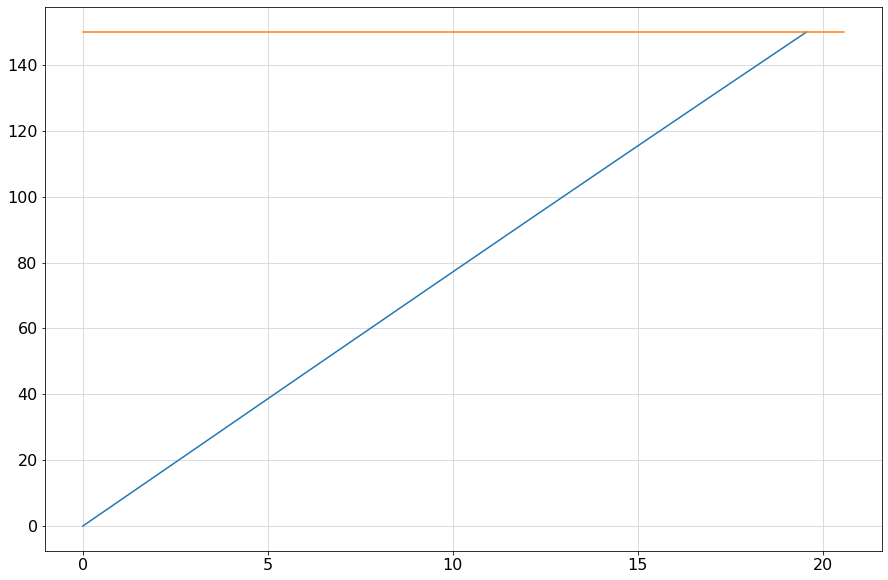

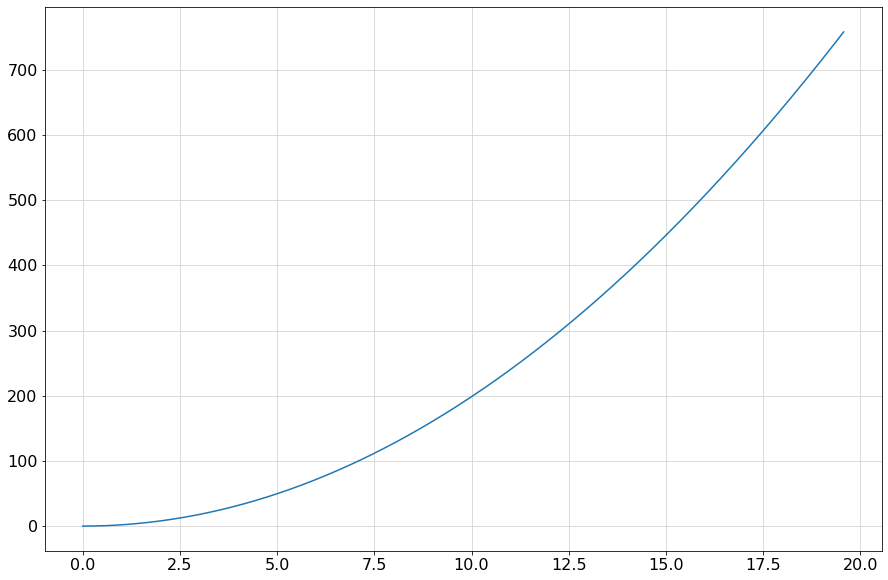

In [18]:
plt.plot(sol_rollout.t,Knots(sol_rollout.y[0]))
plt.plot([0,sol_rollout.t[-1]+1],[V_abort,V_abort])
plt.show()
plt.plot(sol_rollout.t,sol_rollout.y[1])
plt.show()

### Stopping

In [19]:
%%time
def brake(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = -0.5 * g
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

def stop(t,y):
    Vx = y[0]
    return Vx
stop.terminal = True

x0 = sol_rollout.y[1][-1]
v0 = sol_rollout.y[0][-1]
y0 = np.array([v0,x0])

sol_brake = solve_ivp(brake,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

Wall time: 2.3 s


In [20]:
sol_brake.t[-1]

15.730886850155589

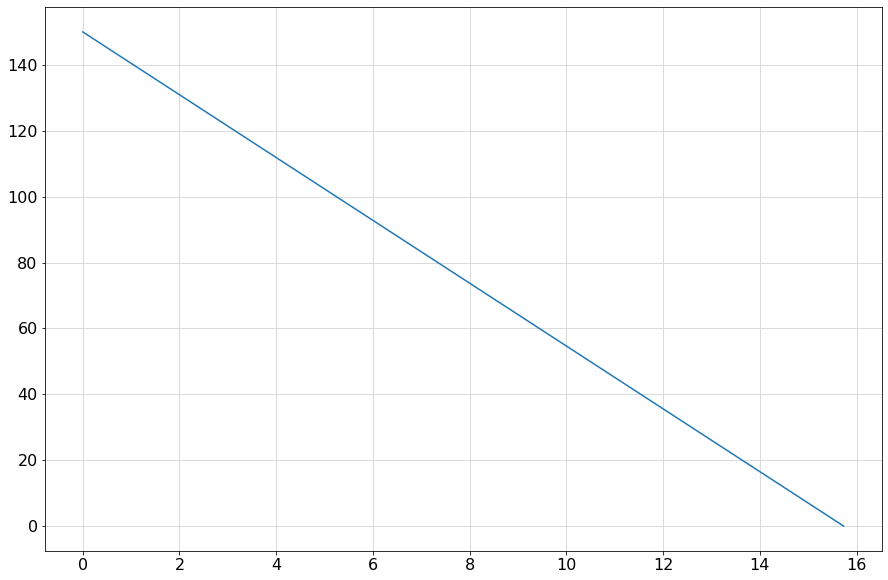

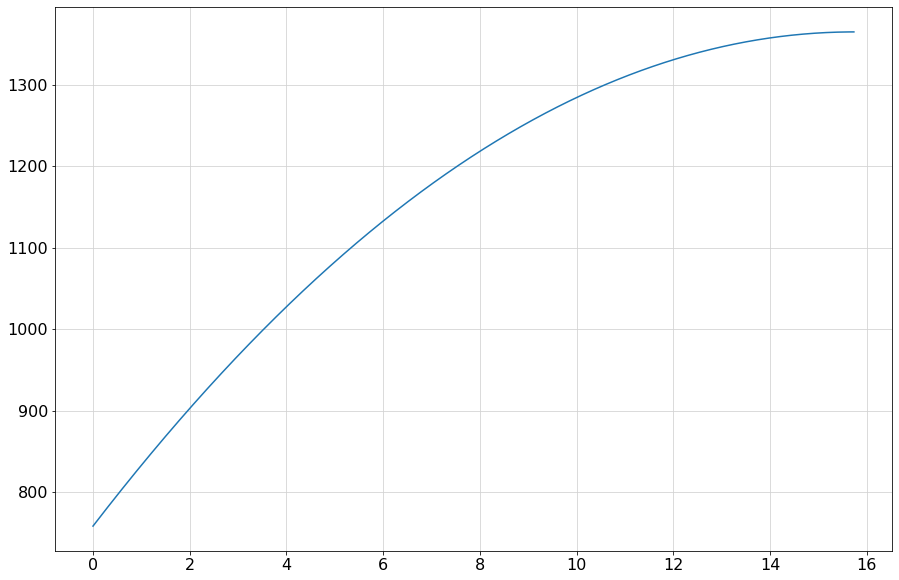

In [21]:
plt.plot(sol_brake.t,Knots(sol_brake.y[0]))
plt.show()
plt.plot(sol_brake.t,sol_brake.y[1])
plt.show()

In [22]:
print('Run stopped at {:.6f}'.format(sol_brake.t[-1]))
print('Run length     {:.6f}'.format(sol_brake.y[1][-1]))

Run stopped at 15.730887
Run length     1365.147983


## Take-off to 35ft

Notes:
 - For engine failure, thrust is dependent on the velocity, cut engine at speed just after V1

### Ground Run

In [73]:
%%time

def rollout(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

Vr = 200

def Vr_set(t,y):
    Vx = y[0]
    return Vx - MS(Vr)
Vr_set.terminal = True

x0 = 0
v0 = 0
y0 = np.array([v0,x0])

sol_rollout = solve_ivp(rollout,[0,50],y0,rtol=1e-9,max_step=1e-3,events=[Vr_set])

Wall time: 4.86 s


In [74]:
print('Vx : ', sol_rollout.y[0][-1])
print('X  : ', sol_rollout.y[1][-1])

Vx :  102.88
X  :  1361.6587154591416


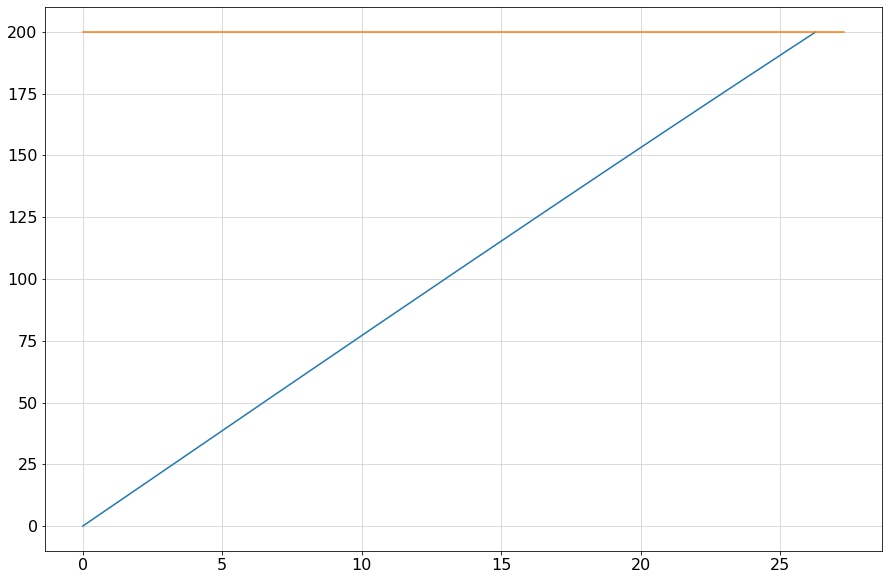

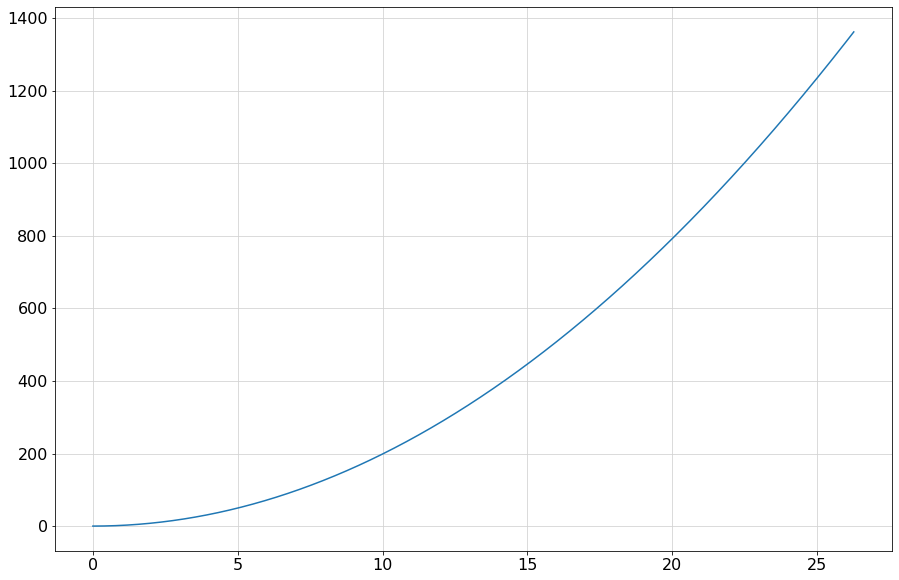

In [75]:
plt.plot(sol_rollout.t,Knots(sol_rollout.y[0]))
plt.plot([0,sol_rollout.t[-1]+1],[Vr,Vr])
plt.show()
plt.plot(sol_rollout.t,sol_rollout.y[1])
plt.show()

### Transition / Rotate

Remember:
 - Friction still present in roatation
 - Change in AoA
 - Track Angle remains 0
 

In [76]:
rotate_rate = 5

#V_LOF - Lift=Weight
def LOF(t,y):
    L = Lift(y[0],y[2])*np.cos(np.radians(y[2]))    
    W = m * g
    return L - W
LOF.terminal = True

def rotate(t,y):
    Vx = y[0]
    X = y[1]
    Alpha = y[2]
    
    dVxdt = (1/m) * ((T_L + T_R)*np.cos(np.radians(Alpha)) - D(Vx,0,Alpha) - D_f(Vx,Alpha))
    dAlphadt = rotate_rate
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt,dAlphadt])

In [77]:
# initial conditions
x0  = sol_rollout.y[1][-1] # initial s
vx0 = sol_rollout.y[0][-1] # initial v
alpha0 = 0

# combine s and v into array y0
y0 = np.array([vx0,x0,alpha0])

sol_rotate = solve_ivp(rotate,[0,20],y0,rtol=1e-9,max_step = 1e-3,events=[LOF])

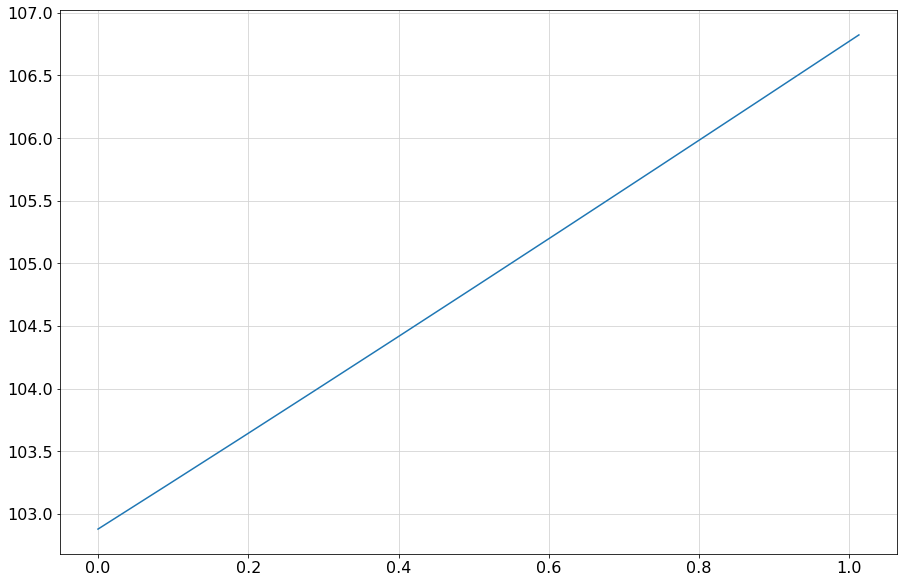

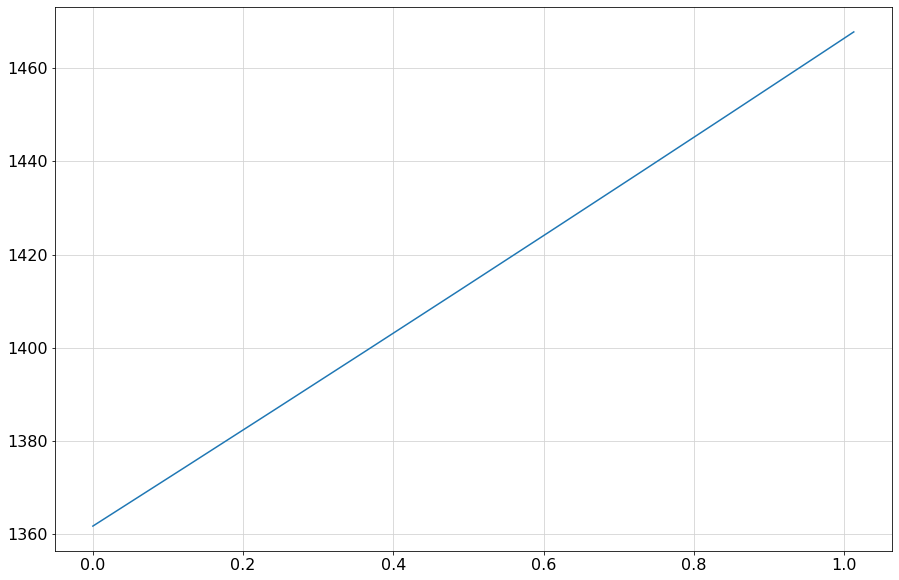

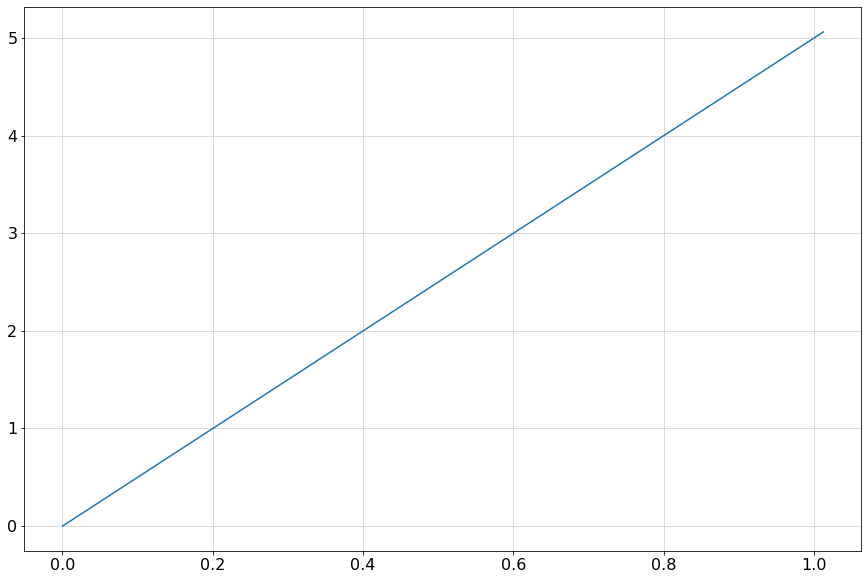

In [78]:
plt.plot(sol_rotate.t,sol_rotate.y[0]) # vx
plt.show()
plt.plot(sol_rotate.t,sol_rotate.y[1]) # x
plt.show()
plt.plot(sol_rotate.t,sol_rotate.y[2]) # alpha
plt.show()

### Climb Out to 35ft

In [79]:
alpha = theta = sol_rotate.y[2][-1]
alpha

5.063382209007386

In [30]:
%%time

def ScreenHeight(t,y):
    return y[3] - 10.7
ScreenHeight.terminal = True

def f(t,y):
    Vx = y[0]  
    Vz = y[1]
    X = y[2]              # extract v from array y 
    H = y[3]
    
    V = np.sqrt(Vx**2 + Vz**2)

    dVxdt = (1/m) * ((T_L + T_R)*np.cos(np.radians(theta)) - D(V,0,theta)*np.cos(np.radians(theta)) - Lift(V,theta)*np.sin(np.radians(theta)))
    dVzdt = (1/m) * ((T_L + T_R)*np.sin(np.radians(theta)) + Lift(V,theta)*np.cos(np.radians(theta)) - m*g - D(V,0,theta)*np.sin(np.radians(theta)))
    dXdt = Vx - Vw
    dHdt = Vz
    
    return np.array([dVxdt, dVzdt, dXdt, dHdt]) # return array


# initial conditions
x0 = sol_rotate.y[1][-1] # initial s
vz0 = 0 # initial v
h0 = 0
vx0 = sol_rotate.y[0][-1]

# combine s and v into array y0
y0 = np.array([vx0,vz0,x0,h0])

sol_LOF = solve_ivp(f,[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[ScreenHeight])

Wall time: 1.68 s


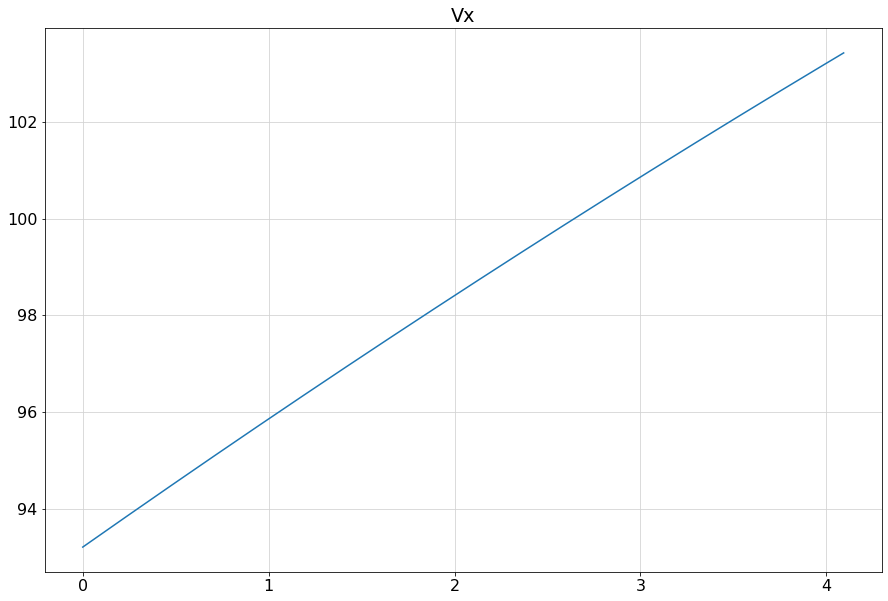

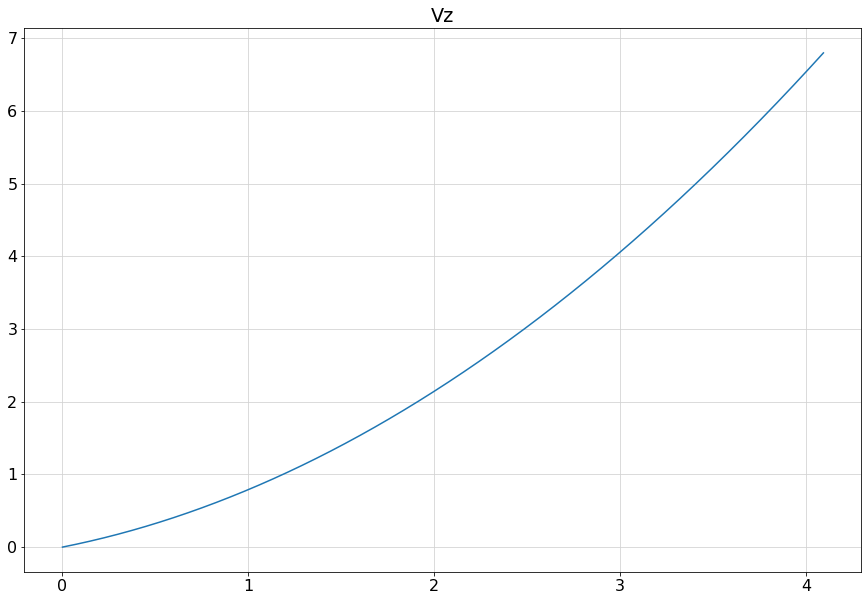

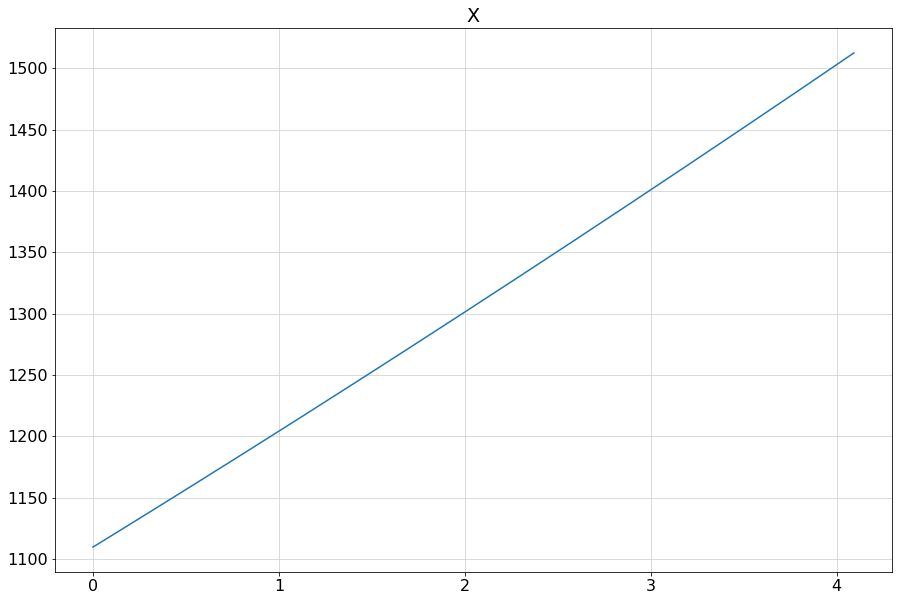

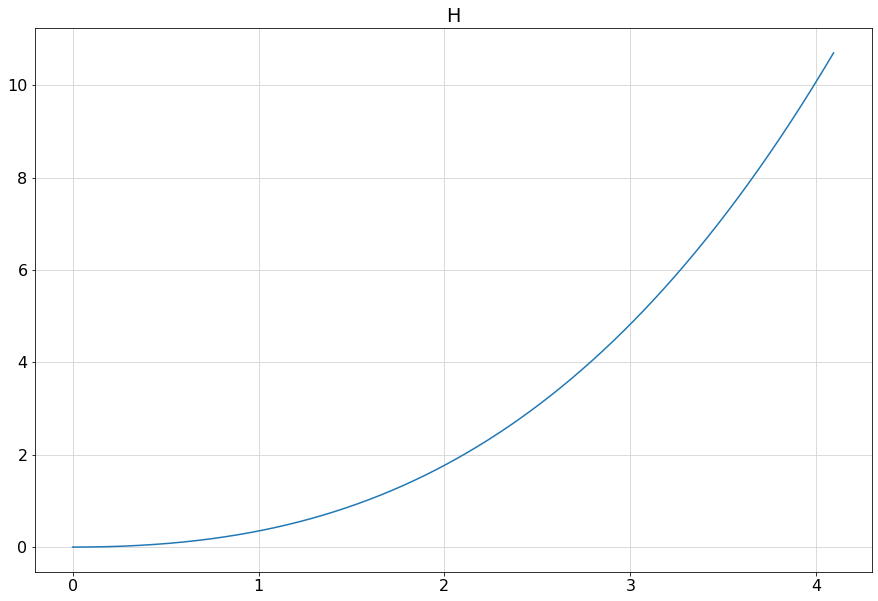

In [31]:
plt.title('Vx')
plt.plot(sol_LOF.t,sol_LOF.y[0])
plt.show()
plt.title('Vz')
plt.plot(sol_LOF.t,sol_LOF.y[1])
plt.show()
plt.title('X')
plt.plot(sol_LOF.t,sol_LOF.y[2])
plt.show()
plt.title('H')
plt.plot(sol_LOF.t,sol_LOF.y[3])
plt.show()

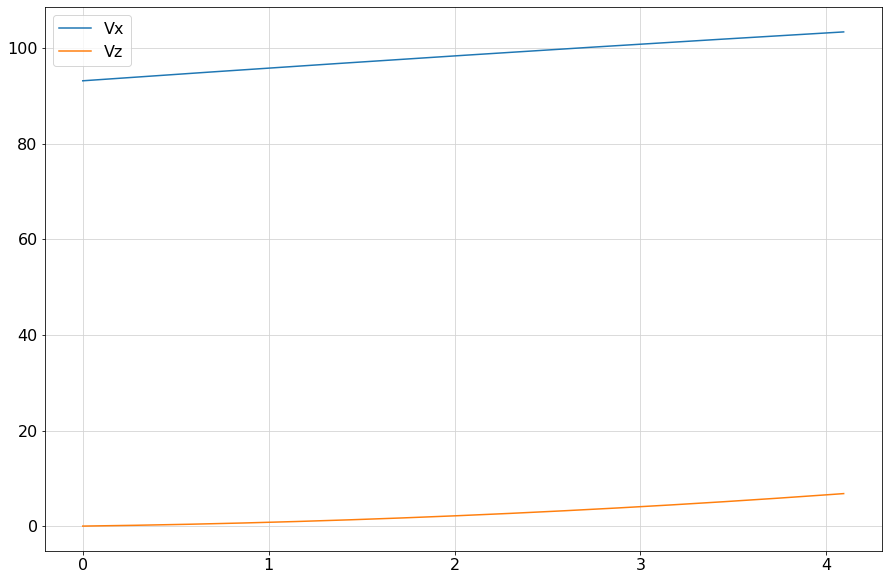

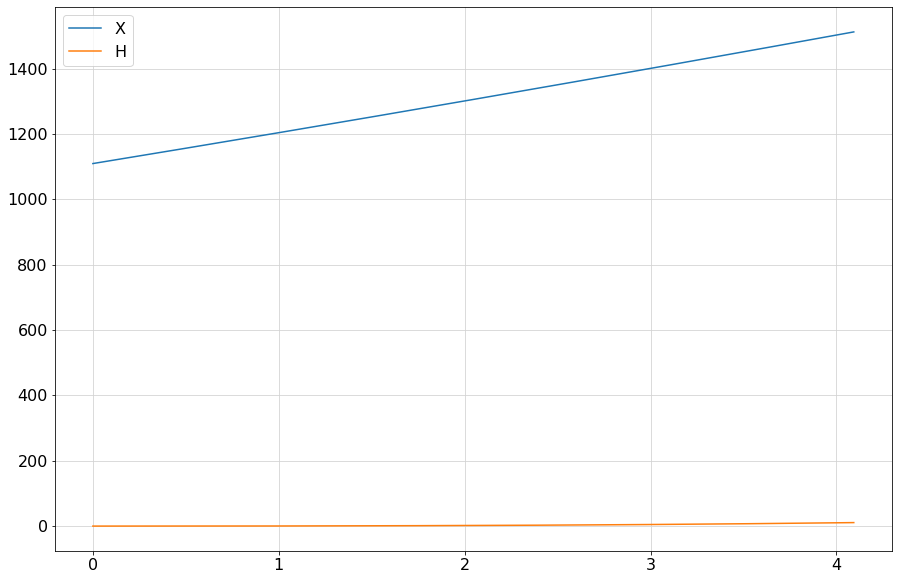

In [32]:
plt.plot(sol_LOF.t,sol_LOF.y[0],label = 'Vx')
plt.plot(sol_LOF.t,sol_LOF.y[1],label = 'Vz')
plt.legend()
plt.show()
plt.plot(sol_LOF.t,sol_LOF.y[2],label = 'X')
plt.plot(sol_LOF.t,sol_LOF.y[3],label = 'H')
plt.legend()
plt.show()

In [33]:
sol_LOF.y[2][-1]

1512.6933640286131

In [34]:
Knots(sol_LOF.y[0][-1])

201.0750643503091

In [35]:
Knots(sol_LOF.y[1][-1])

13.220592109268845

In [36]:
np.sqrt((Knots(sol_LOF.y[0][-1]))**2+(Knots(sol_LOF.y[1][-1]))**2)

201.50921953895957

In [37]:
at = np.arctan(sol_LOF.y[1][-1]/sol_LOF.y[0][-1])

In [38]:
np.degrees(at)

3.761756438997173

pitch angle / track angle / speed / speed at screen height

## V1 AEO Acc-Stop

In [39]:
%%time
V_abort = 150

def accel(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    return np.array([dVxdt,dXdt])

def brake(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = -0.5 * g
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

def Abort(t,y):
    Vx = y[0]
    return Vx - MS(V_abort)
Abort.terminal = True

def stop(t,y):
    Vx = y[0]
    return Vx
stop.terminal = True



x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_rollout = solve_ivp(rollout,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[Abort])

x0 = sol_rollout.y[1][-1]
v0 = sol_rollout.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(brake,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

Wall time: 6.04 s


In [40]:
sol_brake.y[1][-1]

1365.1479827823975

In [41]:
def find_V1(V_t):
    def V1Abort(t,y):
        Vx = y[0]
        return Vx - MS(V_t)
    V1Abort.terminal = True

    print(V_t)
    
    x0 = 0
    v0 = 0
    y0 = np.array([v0,x0])
    sol_accel = solve_ivp(accel,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[V1Abort])

    x0 = sol_accel.y[1][-1]
    v0 = sol_accel.y[0][-1]
    y0 = np.array([v0,x0])
    sol_brake = solve_ivp(brake,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[stop])
    
    return sol_brake.y[1][-1] - RunwayLength

In [42]:
find_V1(150)

150


-284.85201721760245

In [43]:
from scipy.optimize import newton
newton(find_V1,160, tol=1e-0)

160.0
160.0161
164.86033443063076


164.78542967776076

In [44]:
V_abort = newton(find_V1,160,tol=1e-0)

x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_rollout = solve_ivp(rollout,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[Abort])

x0 = sol_rollout.y[1][-1]
v0 = sol_rollout.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(brake,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

160.0
160.0161
164.86033443063076


In [45]:
sol_brake.y[1][-1]

1649.9772828180012

In [46]:
V_abort = np.floor(V_abort)

x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_rollout = solve_ivp(rollout,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[Abort])

x0 = sol_rollout.y[1][-1]
v0 = sol_rollout.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(brake,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])
sol_brake.y[1][-1]

1634.1513018361497

In [47]:
sol_rollout.t[-1]

21.43349017692101

# V1 Acc-Go
## Calc Vr

To calculate Vr, V2 is set at 1.2*Vs (the stall speed), this is to be reached at 35ft above the ground. Vr is the rotatation speed needed in order to obatain this requirement.
So to calculate Vr we look at the climb out to 35ft

Vr is rotation speed such that aircraft leaves ground at climb angle at V_LOF

In [48]:
theta = 12

In [49]:
%%time

def ScreenHeight(t,y):
    return y[3] - 10.7
ScreenHeight.terminal = True

def f(t,y):
    Vx = y[0]  
    Vz = y[1]
    X = y[2]              # extract v from array y 
    H = y[3]
    
    V = np.sqrt(Vx**2 + Vz**2)

    dVxdt = (1/m) * ((T_L + T_R)*np.cos(np.radians(theta)) - D(V,0,theta)*np.cos(np.radians(theta)) - Lift(V,theta)*np.sin(np.radians(theta)))
    dVzdt = (1/m) * ((T_L + T_R)*np.sin(np.radians(theta)) + Lift(V,theta)*np.cos(np.radians(theta)) - m*g - D(V,0,theta)*np.sin(np.radians(theta)))
    dXdt = Vx
    dHdt = Vz
    
    return np.array([dVxdt, dVzdt, dXdt, dHdt]) # return array

Wall time: 0 ns


In [50]:
def V2_search(V_t):
    # initial conditions
    x0 = sol_rotate.y[1][-1] # initial s
    vz0 = 0 # initial v
    h0 = 0
    vx0 = V_t

    # combine s and v into array y0
    y0 = np.array([vx0,vz0,x0,h0])
    print(y0)
    sol_t = solve_ivp(f,[0,10],y0,rtol=1e-9,max_step = 1e-3,events=[ScreenHeight])
    return np.sqrt(sol_t.y[0][-1]**2 + sol_t.y[1][-1]**2) - V2

In [51]:
V2

82.46745336708967

In [52]:
from scipy.optimize import newton

In [53]:
V_lof = newton(V2_search,V2)
V_lof

[  82.46745337    0.         1109.70087805    0.        ]
[  82.47580011    0.         1109.70087805    0.        ]
[  76.95687597    0.         1109.70087805    0.        ]
[  75.89159273    0.         1109.70087805    0.        ]
[  75.31910356    0.         1109.70087805    0.        ]
[  75.17102657    0.         1109.70087805    0.        ]
[  75.14940421    0.         1109.70087805    0.        ]
[  75.14859647    0.         1109.70087805    0.        ]
[  75.14859242    0.         1109.70087805    0.        ]


75.14859241645249

In [54]:
V2_search(V_lof)

[  75.14859242    0.         1109.70087805    0.        ]


7.105427357601002e-14

V1, Vr, VLOF, V2

In [55]:
Lift(V_lof,theta) - m*g

-8087.963444205234

In [56]:
theta

12

In [57]:
sol_rotate.y[0]

array([87.448     , 87.45184773, 87.45569564, ..., 93.19447446,
       93.19843842, 93.20143725])

V2 gives Vlof, Vlof gives Vr?

# _

climb angle needed so that aircraft vlof is when aircrfat leaves ground i.e. L component = W, and V2min is met at 35ft

Vr is rotation initiated such that climb angle met at LOF

V1 min speed needed such that takeoff can be rreached OEO

V2 is a given at 1.2 * Vs

In [58]:
def ScreenHeight(t,y):
    return y[3] - 10.7
ScreenHeight.terminal = True

def f_OEI(t,y):
    Vx = y[0]  
    Vz = y[1]
    X = y[2]              # extract v from array y 
    H = y[3]
    
    V = np.sqrt(Vx**2 + Vz**2)
    
    dVxdt = (1/m) * ((0 + T_R)*np.cos(np.radians(theta)) - D(V,0,theta)*np.cos(np.radians(theta)) - Lift(V,theta)*np.sin(np.radians(theta)))
    dVzdt = (1/m) * ((0 + T_R)*np.sin(np.radians(theta)) + Lift(V,theta)*np.cos(np.radians(theta)) - m*g - D(V,0,theta)*np.sin(np.radians(theta)))
    dXdt = Vx
    dHdt = Vz
    
    return np.array([dVxdt, dVzdt, dXdt, dHdt]) # return array

In [59]:
V2

82.46745336708967

In [72]:
# V_lof = np.sqrt((2*m*g)/(rho * S * CL(10)))
# Knots(V_lof), V_lof, Lift(V_lof,10)*np.cos(radian(10))

V_lof2 = np.sqrt(((m*g)/np.cos(radian(10)))/(0.5*rho*CL(radian(10))))
Knots(V_lof2), V_lof2, Lift(V_lof2,10)*np.cos(radian(10))

def V_lof3(V):
    return Lift(V,1.375)*np.cos(radian(1.375)) - m*g

V_lof4 = newton(V_lof3,10)
Knots(V_lof4), V_lof4, Lift(V_lof4,10)*np.cos(radian(10)) - m*g

(299.88205973498816, 154.2593315276779, 1325699.3631345946)

In [61]:
def climb(a):
    # initial conditions
    global theta
    theta = a
    x0 = sol_rotate.y[1][-1] # initial s
    vz0 = 0 # initial v
    h0 = 0
    vx0 = np.sqrt((2*m*g)/(rho * S * CL(a)))

    # combine s and v into array y0
    y0 = np.array([vx0,vz0,x0,h0])
    print(y0)
    sol_t = solve_ivp(f_OEI,[0,10],y0,rtol=1e-9,max_step = 1e-3,events=[ScreenHeight])
    return np.sqrt(sol_t.y[0][-1]**2 + sol_t.y[1][-1]**2) - V2

In [62]:
climb(10)

[  81.79658554    0.         1109.70087805    0.        ]


-0.4607071870684081

In [63]:
climb(8.9)

[  85.82475043    0.         1109.70087805    0.        ]


4.996823048082973

In [64]:
climb(10.5)

[  80.14395891    0.         1109.70087805    0.        ]


-2.8298216025718403

In [65]:
from scipy.optimize import newton

In [66]:
newton(climb,10)

[  81.79658554    0.         1109.70087805    0.        ]
[  81.79283679    0.         1109.70087805    0.        ]
[  82.12127884    0.         1109.70087805    0.        ]
[  82.11961295    0.         1109.70087805    0.        ]
[  82.1196214     0.         1109.70087805    0.        ]


9.905776334701997

In [76]:
np.sqrt((2*m*g)/(rho * S * CL(9.9)))

82.13954966941296

In [68]:
climb_angle = np.round(newton(climb,10),1)
print(climb_angle)
# initial conditions
x0 = sol_rotate.y[1][-1] # initial s
vz0 = 0 # initial v
h0 = 0
vx0 = np.sqrt((2*m*g)/(rho * S * CL(climb_angle)))

# combine s and v into array y0
y0 = np.array([vx0,vz0,x0,h0])
sol_c = solve_ivp(f,[0,10],y0,rtol=1e-9,max_step = 1e-3,events=[ScreenHeight])

[  81.79658554    0.         1109.70087805    0.        ]
[  81.79283679    0.         1109.70087805    0.        ]
[  82.12127884    0.         1109.70087805    0.        ]
[  82.11961295    0.         1109.70087805    0.        ]
[  82.1196214     0.         1109.70087805    0.        ]
9.9


In [69]:
theta = climb_angle
V_lof = np.sqrt((2*m*g)/(rho * S * CL(climb_angle)))

In [70]:
V_lof

82.13954966941296

In [71]:
Knots(V_lof)

159.68030651130047

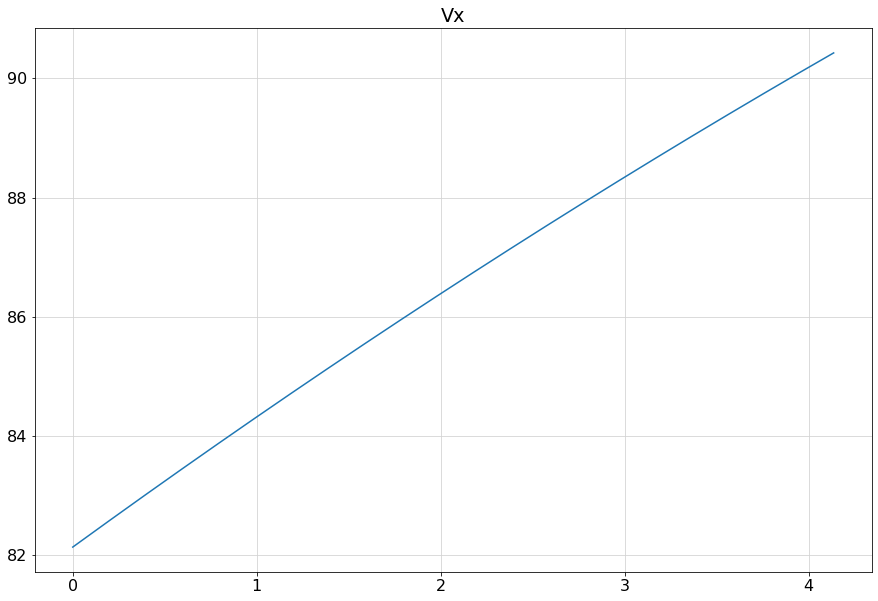

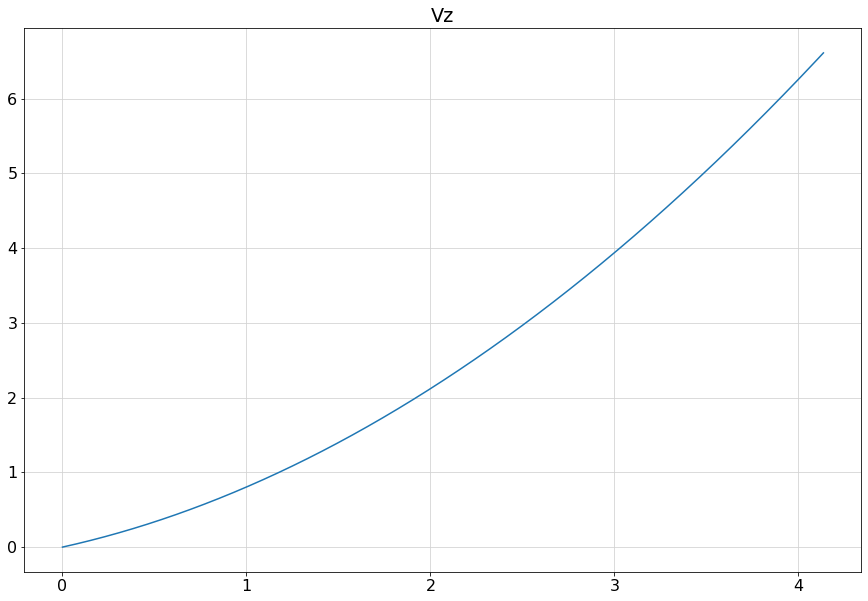

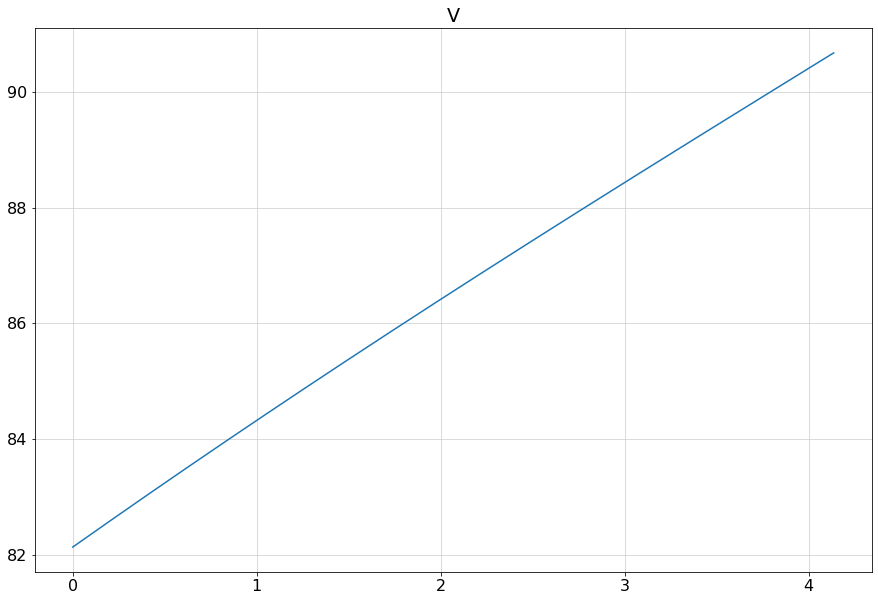

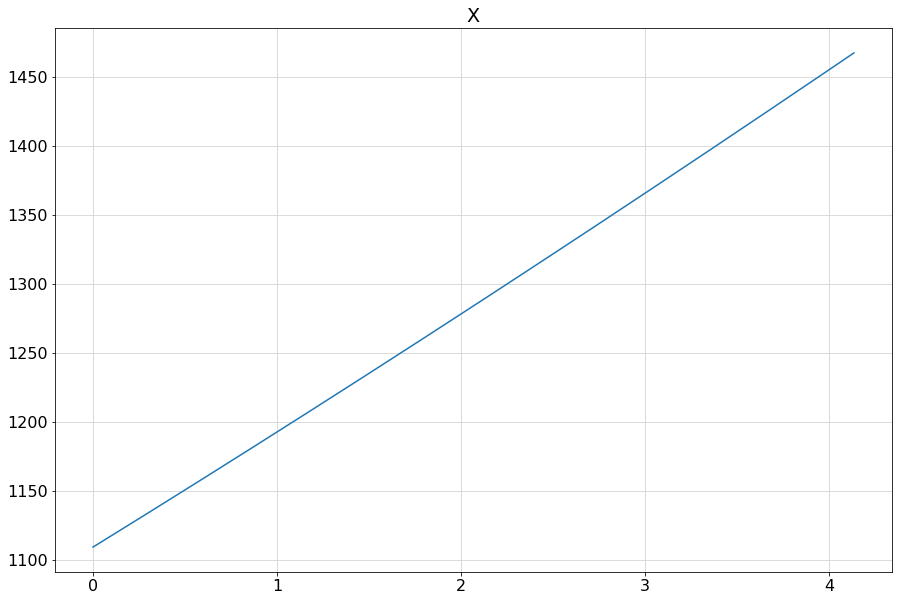

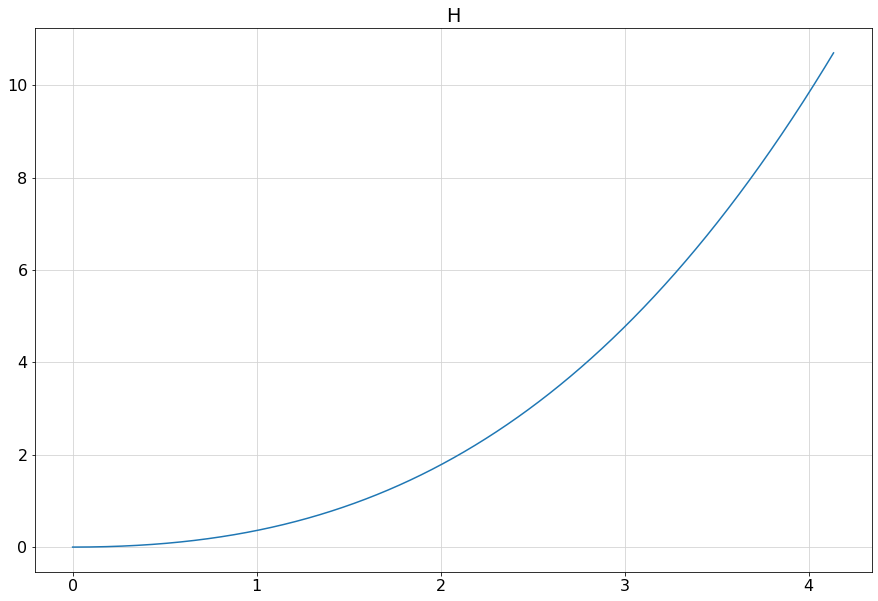

In [72]:
plt.title('Vx')
plt.plot(sol_c.t,sol_c.y[0])
plt.show()
plt.title('Vz')
plt.plot(sol_c.t,sol_c.y[1])
plt.show()
plt.title('V')
plt.plot(sol_c.t,np.sqrt(sol_c.y[0]**2+sol_c.y[1]**2))
plt.show()
plt.title('X')
plt.plot(sol_c.t,sol_c.y[2])
plt.show()
plt.title('H')
plt.plot(sol_c.t,sol_c.y[3])
plt.show()

## Vr

In [73]:
rotate_rate = 3

def V_LOF(t,y):
    return y[0] - V_lof
V_LOF.terminal = True

def rotate_OEI(t,y):
    Vx = y[0]
    X = y[1]
    Alpha = y[2]
    
    dVxdt = (1/m) * ((0 + T_R)*np.cos(np.radians(Alpha)) - D(Vx,0,Alpha) - D_f(Vx,Alpha))
    dXdt = Vx - Vw
    dAlphadt = rotate_rate
    
    return np.array([dVxdt,dXdt,dAlphadt])

In [74]:
def rotation(Vr):
    # initial conditions
    x0  = sol_rollout.y[1][-1] # initial s
    vx0 = MS(Vr)
    alpha0 = 0

    # combine s and v into array y0
    y0 = np.array([vx0,x0,alpha0])
    print(y0)
    sol_rot = solve_ivp(rotate_OEI,[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[V_LOF])
    return sol_rot.y[2][-1] - climb_angle


In [79]:
Vr = newton(rotation,150)

[ 77.16       908.67937986   0.        ]
[ 77.16776744 908.67937986   0.        ]
[ 76.46910518 908.67937986   0.        ]
[ 76.4716689  908.67937986   0.        ]
[ 76.47165772 908.67937986   0.        ]


In [80]:
Vr, MS(Vr)

(148.6618540489643, 76.47165772278723)

In [81]:
Knots(V_lof)

159.68030651130047

In [82]:
# initial conditions
x0  = sol_rollout.y[1][-1] # initial s
vx0 = MS(Vr)
alpha0 = 0

# combine s and v into array y0
y0 = np.array([vx0,x0,alpha0])
sol_rotate = solve_ivp(rotate_OEI,[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[V_LOF])
sol_rotate.y[0][-1]

82.13954966941296

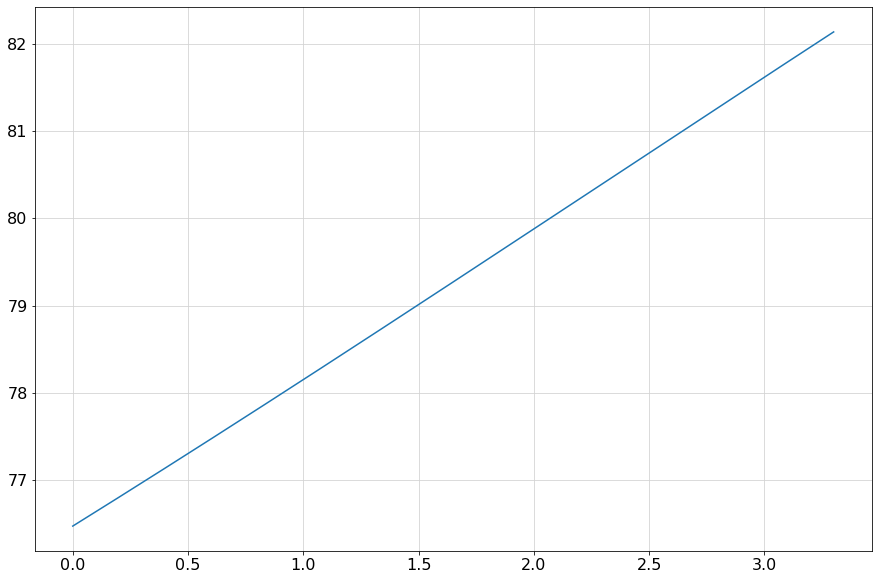

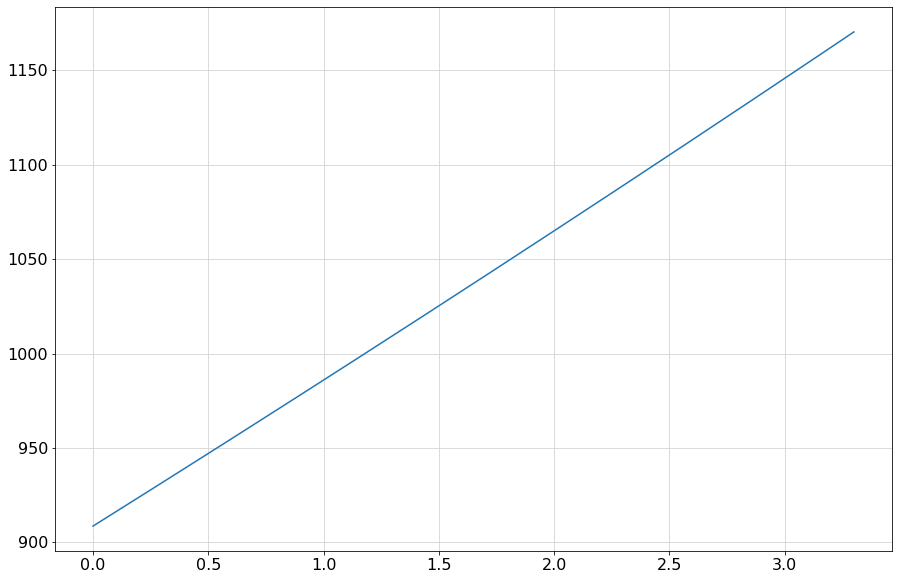

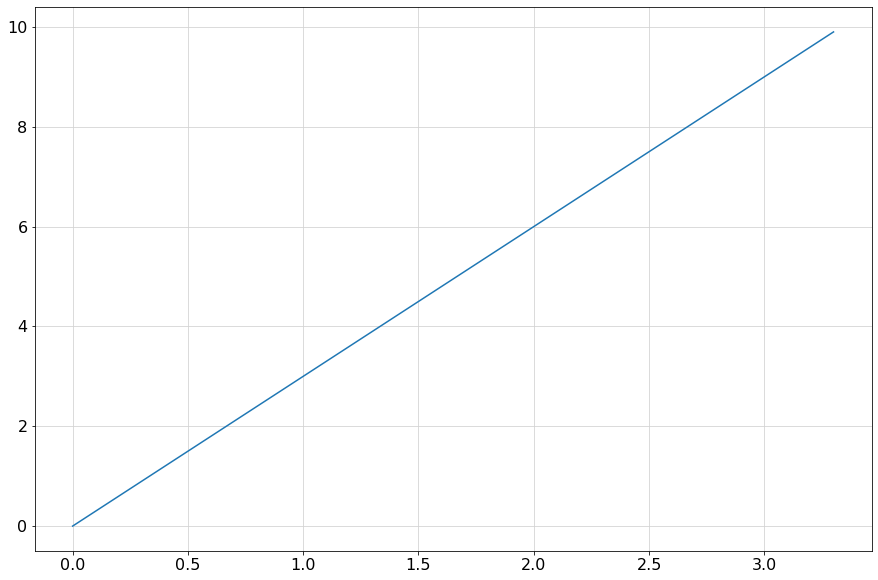

In [83]:
plt.plot(sol_rotate.t,sol_rotate.y[0]) # vx
plt.show()
plt.plot(sol_rotate.t,sol_rotate.y[1]) # x
plt.show()
plt.plot(sol_rotate.t,sol_rotate.y[2]) # alpha
plt.show()

## V1

min speed needed to safely continue takeoff, i.e what speed needed to continue with only one engine left
i have Vr, V2, angle to climb out to obstacle with OEI

speed needed to be able to get into the air before end of runway

V1 <= Vr

If AEO take-off run length is greater than runway available, runway airfield not suitable, different airport or weight required.
same whill apply if V1 > Vr

What speed is needed so that possible to accelerate upto Vr, rotate and climb before end of runway
min speed therefore max limit (total length equals total available

 engine fails at V1, pick a speed for V1, attempt the takeoff if run too long increase V1, repeat until within length of runway.

In [84]:
V1 = Vr
print(V1)
print(Vr)
print(V_lof)
#Speeds
#   Vr
#   Vlof

#Stages
#  Accel to V1 (AEO)
def toV1(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

#  Accel to Vr (OEI)
def V1Vr(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((0 + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

#  Rotation (OEI)
def rotate(t,y):
    Vx = y[0]
    X = y[1]
    Alpha = y[2]
    
    dVxdt = (1/m) * ((T_L + T_R)*np.cos(np.radians(Alpha)) - D(Vx,0,Alpha) - D_f(Vx,Alpha))
    dXdt = Vx - Vw
    dAlphadt = rotate_rate
    
    return np.array([dVxdt,dXdt,dAlphadt])

#  Climb (OEI)
def climbout(t,y):
    Vx = y[0]  
    Vz = y[1]
    X = y[2]               
    H = y[3]
    
    V = np.sqrt(Vx**2 + Vz**2)
    dVxdt = (1/m) * ((T_L + T_R)*np.cos(np.radians(theta)) - D(V,0,theta)*np.cos(np.radians(theta)) - Lift(V,theta)*np.sin(np.radians(theta)))
    dVzdt = (1/m) * ((T_L + T_R)*np.sin(np.radians(theta)) + Lift(V,theta)*np.cos(np.radians(theta)) - m*g - D(V,0,theta)*np.sin(np.radians(theta)))
    dXdt = Vx - Vw
    dHdt = Vz
    
    return np.array([dVxdt, dVzdt, dXdt, dHdt]) 

#Constraints
#  V1
def set_V1(t,y):
    Vx = y[0]
    return Vx - MS(V1)
set_V1.terminal = True

#  Vr
def set_Vr(t,y):
    Vx = y[0]
    return Vx - MS(Vr)
set_Vr.terminal = True

#  Vlof
def V_LOF(t,y):
    return y[0] - V_lof
V_LOF.terminal = True

#  Screen Height (35ft)
def ScreenHeight(t,y):
    return y[3] - 10.7
ScreenHeight.terminal = True

#Calculations
#  upto V1
print('V1')
x0 = 0
v0 = 0
y0 = np.array([v0,x0])

sol_V1 = solve_ivp(toV1,[0,60],y0,rtol=1e-9,max_step=1e-3,events=[set_V1])

#  V1 to Vr
if Vr != V1:
    print('V1Vr')
    x0 = sol_V1.y[1][-1]
    v0 = sol_V1.y[0][-1]
    y0 = np.array([v0,x0])

    sol_Vr = solve_ivp(V1Vr,[0,60],y0,rtol=1e-9,max_step=1e-3,events=[set_Vr])
else:
    print('Vr = V1')
    sol_Vr = sol_V1
        
#  Rotation (Vr to Vlof)
print('rotate')
x0  = sol_Vr.y[1][-1]
vx0 = sol_Vr.y[0][-1]
alpha0 = 0
y0 = np.array([vx0,x0,alpha0])

sol_VrVlof = solve_ivp(rotate,[0,60],y0,rtol=1e-9,max_step = 1e-3,events=[V_LOF])

#  Climb (Vlof to V2)
print('climb')
# alpha = theta = sol_rotate.y[2][-1]

x0 = sol_VrVlof.y[1][-1]
vx0 = sol_VrVlof.y[0][-1]
vz0 = 0
h0 = 0
y0 = np.array([vx0,vz0,x0,h0])

sol_climb = solve_ivp(climbout,[0,60],y0,rtol=1e-9,max_step = 1e-3,events=[ScreenHeight])

148.6618540489643
148.6618540489643
82.13954966941296
V1
Vr = V1
rotate
climb


In [85]:
sol_V1.y[0][-1], sol_V1.y[1][-1]

(76.47165772278723, 744.6120731108524)

In [86]:
sol_Vr.y[0][-1], sol_Vr.y[1][-1]

(76.47165772278723, 744.6120731108524)

In [87]:
sol_VrVlof.y[0][-1], sol_VrVlof.y[1][-1], sol_VrVlof.y[2][-1]

(82.13954966941296, 859.2029350969168, 4.335291952826157)

In [88]:
sol_climb.y[0][-1], sol_climb.y[1][-1], sol_climb.y[2][-1], sol_climb.y[3][-1]

(90.44578743561439, 6.610758053563608, 1217.287970705961, 10.699999999999998)

In [ ]:
plt.title('Vx')
plt.plot(sol_climb.t,sol_climb.y[0])
plt.show()
plt.title('Vz')
plt.plot(sol_climb.t,sol_climb.y[1])
plt.show()
plt.title('X')
plt.plot(sol_climb.t,sol_climb.y[2])
plt.show()
plt.title('H')
plt.plot(sol_climb.t,sol_climb.y[3])
plt.show()

V2 2.4% climb one engine

percentage climb rate to angle

need sufficient excess thrust to meet 

In [89]:
V2

82.46745336708967

V2 OEI min climb gradient = 2.4%, what is the speed?

In [95]:
min_a = np.round(np.arctan(24/1000) * 180/np.pi,3)
min_a

1.375

In [119]:
Lift(350,min_a)*np.cos(min_a) - m*g

957.6387597953435

In [102]:
Knots(V_lof)

159.68030651130047

In [127]:
V_s

68.72287780590807

In [128]:
V2

82.46745336708967

In [129]:
V_lof

82.13954966941296

l = (0.5 * rho * V**2 * Cl(a)) *np.cos(a) = m*g

In [ ]:
V = np.sqrt(((m*g)/np.cos(a))/(0.5*rho*Cl(a)))